In [ ]:
from _helper_basics_ import *
%reload_ext autoreload

In [1]:
import sys
## To get helper functions from another folder
# sys.path.insert(0, '../') # if _helper_basics_ is in previous folder
now_i_am_at = 'home' # home dso test
if now_i_am_at=='home': sys.path.insert(0, 'E:/Leonard HDD/Dropbox/DSO/Tasks/')
elif now_i_am_at=='dso': sys.path.insert(0, 'D:/Dropbox/DSO/Tasks')

from _helper_basics_ import *

%matplotlib inline
plt.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

print('keras', keras.__version__)
print('tensorflow', tf.__version__)

Using TensorFlow backend.


keras 2.0.8
tensorflow 1.3.0


In [52]:
def build_model_reg(n_classes, conv_activ, filt_incept, num_incept=2, reg_l1=0., reg_l2=0.):
    def Inception_block(Inp, filt_incept, conv_activ, padding='same', ell=None, reg_l1=0., reg_l2=0.):
        x_1a = conv2dBlock(Inp, filt_incept[0], kernel_size=1, conv_activ=conv_activ, padding=padding, name=str(ell)+'_1a', reg_l1=reg_l1, reg_l2=reg_l2)
        x_1b = conv2dBlock(Inp, filt_incept[1], kernel_size=1, conv_activ=conv_activ, padding=padding, name=str(ell)+'_1b', reg_l1=reg_l1, reg_l2=reg_l2)
        x_1c = conv2dBlock(Inp, filt_incept[2], kernel_size=1, conv_activ=conv_activ, padding=padding, name=str(ell)+'_1c', reg_l1=reg_l1, reg_l2=reg_l2)
        x_3 = conv2dBlock(x_1b, filt_incept[3], kernel_size=3, conv_activ=conv_activ, padding=padding, name=str(ell)+'_3', reg_l1=reg_l1, reg_l2=reg_l2)
        x_5 = conv2dBlock(x_1c, filt_incept[4], kernel_size=5, conv_activ=conv_activ, padding=padding, name=str(ell)+'_5', reg_l1=reg_l1, reg_l2=reg_l2)

        x = concatenate([x_1a,x_3,x_5])
        return x
        
    def conv2dBlock(Inp, filters, kernel_size=2, conv_activ='selu', padding='same', name=None, reg_l1=0., reg_l2=0.):
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='linear', padding=padding, kernel_initializer='lecun_normal', 
                   kernel_regularizer=l2(reg_l2), name=name+'_Conv2D')(Inp)
        if not conv_activ=='linear':
            # x = BatchNormalization(axis=3, name=name+'_BN')(x)
            x = Activation(conv_activ, name=name+'_'+conv_activ)(x)
        return x
   
    ######################### Build Architecture ##########################
    Inp = Input(shape=(28,28,1)); ell=0
    ## Initial Conv Layer
    x = conv2dBlock(Inp, 32, kernel_size=1, conv_activ=conv_activ, name='0_Conv2D', reg_l2=reg_l2); ell+=1

    ## Inception Modules
    for _ in range(num_incept):
        x = Inception_block(x, filt_incept[ell], conv_activ, ell=ell, reg_l2=reg_l2); ell+=1

    ## Final Conv Layer
    x = conv2dBlock(x, 32, kernel_size=1, conv_activ=conv_activ, name=str(ell)+'_Conv2D', reg_l2=reg_l2); ell+=1

    ## Classifier Net
    x = GlobalAveragePooling2D(name='GlobalAvgPool')(x) #     x = Flatten(name='Flatten')(x)
    x = Dense(200, activation=conv_activ, name = "Dense_"+str(ell)+"_"+conv_activ)(x)
    x = AlphaDropout(0.2)(x)

    x = Dense(n_classes, activation='softmax', name = "Outputlayer")(x)
    train_model = Model(Inp, x)
    return train_model

# train_model = build_model_reg()
########################## Printing information ###########################
# build_model_reg(n_classes=40, conv_activ='linear', reg_l2=0.).summary()
# print_model_weights(build_model_reg())

In [4]:
def predict_top_1_4_acc(X_train, X_test, Y_train,Y_test, Y_hat_train, Y_hat_test):
    ## Top-1 Accuracy
    ################################### Training Set ###################################
    count = 0
    for idx in range(len(Y_train)):
        if np.argmax(Y_hat_train[idx]) == np.argmax(Y_train[idx]): count += 1
    print('Top 1 Accuracy_train : {}%'.format(100.*count/len(Y_train)))
    ################################### Testing Set ###################################
    count = 0
    for idx in range(len(Y_test)):
        if np.argmax(Y_hat_test[idx]) == np.argmax(Y_test[idx]): count += 1
    print('Top 1 Accuracy_test  : {}%'.format(100.*count/len(Y_test)))

    ## Top-4 Accuracy
    ################################### Training Set ###################################
    count = 0
    for idx in range(len(Y_train)):
        ## Prediction
        y_a = Y_hat_train[idx]
        y_hat_top4 = y_a.argsort()[-4:][::-1]
        ## Ground Truth
        y_true = np.argmax(Y_train[idx])
        if y_true in y_hat_top4: count += 1
    print('\nTop 4 Accuracy_train : {}%'.format(100.*count/len(Y_train)))
    ################################### Testing Set ###################################
    count = 0
    for idx in range(len(Y_test)):
        ## Prediction
        y_a = Y_hat_test[idx]
        y_hat_top4 = y_a.argsort()[-4:][::-1]
        ## Ground Truth
        y_true = np.argmax(Y_test[idx])
        if y_true in y_hat_top4: count += 1
    print('Top 4 Accuracy_test  : {}%'.format(100.*count/len(Y_test)))

In [40]:
Archi_dir = "v5/"
Weights_path = Archi_dir+"Logs/"
Ckpt_Mod_Weights_fold = Archi_dir+"Checkpoint_Model_Weights/"
if not os.path.exists(Archi_dir): os.mkdir(Archi_dir)
if not os.path.exists(Weights_path): os.mkdir(Weights_path)
if not os.path.exists(Ckpt_Mod_Weights_fold): os.mkdir(Ckpt_Mod_Weights_fold)
    
plot_path_dir = Archi_dir+'Plots/'
if not os.path.exists(plot_path_dir): os.mkdir(plot_path_dir)

# Data

In [6]:
num_examples_per_class = 2000
classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe', 'banana','bandage','barn','baseball bat','baseball',
           'basket', 'basketball','bathtub','beach','bear','beard','bed','bee','belt', 'bicycle','binoculars','birthday cake','blueberry', 
           'book','boomerang','bottlecap','bowtie','bracelet','brain', 'bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']
num_classes = len(classes)

In [7]:
# x_data = np.load('x_data.npy')
# y_data = np.load('y_data.npy')
# print('x_data', x_data.shape)
# print('y_data', y_data.shape)

X_train = np.load('X_train_normalised_spliced.npy')
Y_train = np.load('Y_train_normalised_spliced.npy')
X_test  = np.load('X_test_normalised_spliced.npy')
Y_test  = np.load('Y_test_normalised_spliced.npy')
print('X_train', X_train.shape)
print('Y_train', Y_train.shape)
print('X_test', X_test.shape)
print('Y_test', Y_test.shape)

X_train (64000, 28, 28, 1)
Y_train (64000, 40)
X_test (12800, 28, 28, 1)
Y_test (12800, 40)


# Setup & Training

In [8]:
######################## Training Parameters ###############################
learning_rate = None;	print('learning_rate',learning_rate)
decay = 0;          	print('decay',decay)
training_epochs = 100;	print('training_epochs',training_epochs)
batch_size = 16;		print('batch_size',batch_size)
######################## Checkpoints ###############################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, cooldown=5, epsilon=1e-05, verbose=1)

learning_rate None
decay 0
training_epochs 100
batch_size 16
training_num : batch_size*2000= 80000


In [57]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(64000, 28, 28, 1)
(64000, 40)
(12800, 28, 28, 1)
(12800, 40)


# Deeper v5_3
    4 inception modules
    Excluded Batch_Norm as 'selu' are already a self normalising activation. 
    Used AlphaDropout isntead of Dropout
    Used 'lecun_normal' for initialisers instead of the default 'glorot_uniform'

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
0_Conv2D_Conv2D (Conv2D)         (None, 28, 28, 32)    64          input_14[0][0]                   
____________________________________________________________________________________________________
0_Conv2D_selu (Activation)       (None, 28, 28, 32)    0           0_Conv2D_Conv2D[0][0]            
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 28, 28, 8)     264         0_Conv2D_selu[0][0]              
___________________________________________________________________________________________

Epoch 00000: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0000_VCA-0.60.hdf5
279s - loss: 2.2817 - categorical_accuracy: 0.3692 - val_loss: 1.4866 - val_categorical_accuracy: 0.6020
Epoch 2/100
Epoch 00001: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0001_VCA-0.68.hdf5
275s - loss: 1.3833 - categorical_accuracy: 0.6108 - val_loss: 1.2131 - val_categorical_accuracy: 0.6759
Epoch 3/100
Epoch 00002: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0002_VCA-0.72.hdf5
274s - loss: 1.1771 - categorical_accuracy: 0.6688 - val_loss: 1.0767 - val_categorical_accuracy: 0.7184
Epoch 4/100
Epoch 00003: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0003_VCA-0.74.hdf5
273s - loss: 1.0625 - categorical_accuracy: 0.7003 - val_loss: 1.0162 - val_categorical_accuracy: 0.7396
Epoch 5/100
Epoch 00004: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0004_VCA-0.75.hd

268s - loss: 0.6049 - categorical_accuracy: 0.8204 - val_loss: 0.4784 - val_categorical_accuracy: 0.8634
Epoch 38/100
Epoch 00037: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0037_VCA-0.85.hdf5
268s - loss: 0.6025 - categorical_accuracy: 0.8247 - val_loss: 0.5036 - val_categorical_accuracy: 0.8509
Epoch 39/100
Epoch 00038: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0038_VCA-0.86.hdf5
268s - loss: 0.5984 - categorical_accuracy: 0.8223 - val_loss: 0.5343 - val_categorical_accuracy: 0.8552
Epoch 40/100
Epoch 00039: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0039_VCA-0.85.hdf5
268s - loss: 0.5934 - categorical_accuracy: 0.8246 - val_loss: 0.5116 - val_categorical_accuracy: 0.8537
Epoch 41/100
Epoch 00040: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0040_VCA-0.86.hdf5
268s - loss: 0.5904 - categorical_accuracy: 0.8264 - val_loss: 0.5075 - val_categorical_accuracy: 0.

Epoch 00073: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0073_VCA-0.94.hdf5
267s - loss: 0.2887 - categorical_accuracy: 0.9075 - val_loss: 0.1994 - val_categorical_accuracy: 0.9387
Epoch 75/100
Epoch 00074: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0074_VCA-0.94.hdf5
267s - loss: 0.2819 - categorical_accuracy: 0.9090 - val_loss: 0.1942 - val_categorical_accuracy: 0.9391
Epoch 76/100
Epoch 00075: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0075_VCA-0.94.hdf5
266s - loss: 0.2727 - categorical_accuracy: 0.9115 - val_loss: 0.1874 - val_categorical_accuracy: 0.9416
Epoch 77/100
Epoch 00076: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0076_VCA-0.94.hdf5
266s - loss: 0.2706 - categorical_accuracy: 0.9127 - val_loss: 0.1825 - val_categorical_accuracy: 0.9426
Epoch 78/100
Epoch 00077: saving model to v5/Checkpoint_Model_Weights/1e-3/weights_LR-1.00e-03_Epoch-0077_VCA-0.9

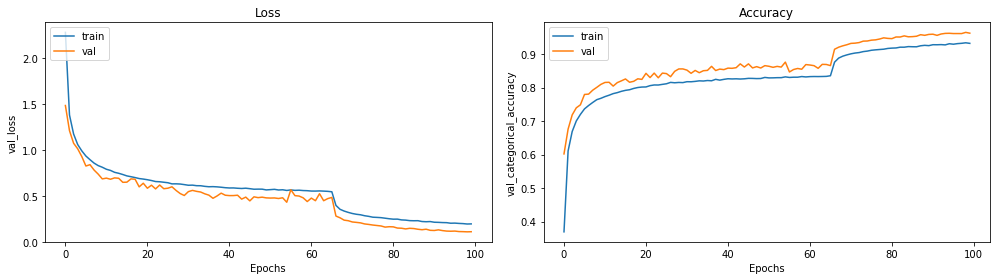

In [53]:
filt_incept = [[], [16, 8, 8, 16, 16], 
                   [32, 16, 16, 32, 32],
                   [32, 16, 16, 32, 32], 
                   [16, 8, 8, 16, 16]]
train_model_v5_3 = build_model_reg(n_classes=40, conv_activ='selu', 
                                   filt_incept=filt_incept, num_incept=len(filt_incept)-1, 
                                   reg_l1=0., reg_l2=0.)
train_model_v5_3.summary()
######################## Training Parameters ###############################
learning_rate = 1e-3;   print('learning_rate',learning_rate)
adam_opt = Adam(lr=learning_rate, decay=decay)
train_model_v5_3.compile(loss=categorical_crossentropy ,optimizer=adam_opt, metrics=['categorical_accuracy'])
######################## Checkpoints ###############################
CkptFold_det = ['{:.2e}'.format(learning_rate), Ckpt_Mod_Weights_fold, '1e-3/'] # [str_int, Ckpt_Mod_Weights_Fold, LR_Fold]
ModelCheckpoint_det = ['val_categorical_accuracy', 1, False, True, 1] # [monitor_modes, verbose_ckpt, save_best_only, save_weights_only, period]
ckpt = ckpt_saving(CkptFold_det, ModelCheckpoint_det, save_all=True)
csv_log = CSVLogger(Weights_path+'v5_3_Trg_log_{:.2e}.txt'.format(learning_rate), '\t')
plot_path = plot_path_dir+'v5_3_{:.2e}.png'.format(learning_rate)
########################### Actual training ##################################
try:
    history_1 = train_model_v5_3.fit(X_train,Y_train, batch_size=batch_size, epochs=training_epochs, verbose=2, 
                                     validation_split = 0., validation_data=(X_test,Y_test), # None (X_val,Y_val)
                                     callbacks=[reduce_lr, csv_log, ckpt]) 
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1);plot_loss(history_1, metric_list=['loss','val_loss'], title='Loss', legend_list=['train', 'val'],  plot_path=plot_path)
    plt.subplot(1,2,2);plot_loss(history_1, metric_list=['categorical_accuracy','val_categorical_accuracy'], title='Accuracy', legend_list=['train', 'val'], plot_path=plot_path)
    plt.tight_layout()
except KeyboardInterrupt:
    print('\n\nKeyboardInterrupt')

In [58]:
## Save Model & Weights
num_model = 3
save_or_load = 'save'
model_path = Weights_path+Archi_dir[:-1]+"_model_v5_"+str(num_model)+".json"
weights_path = Weights_path+Archi_dir[:-1]+"_weights_v5_"+str(num_model)+".h5"
if save_or_load == 'save':
    save_model(train_model_v5_3, model_path, weights_path)
elif save_or_load == 'load':
    train_model_v5_3 = load_model(model_path, 'path', weights_path, 'final')
    # train_model_v5_3.summary()

Saved model : v5/Logs/v5_model_v5_3.json
Saved weights : v5/Logs/v5_weights_v5_3.h5


Top 1 Accuracy_train : 96.04375%
Top 1 Accuracy_test  : 96.25%

Top 4 Accuracy_train : 99.334375%
Top 4 Accuracy_test  : 99.3828125%
idx 3153
Prediction  :16 beach
Ground Truth:16 beach
idx 11264
Prediction  :18 beard
Ground Truth:18 beard


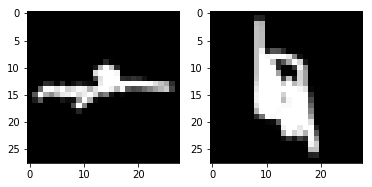

In [56]:
# Y_hat_train = train_model_v5_3.predict(X_train, batch_size=batch_size, verbose=1)
# Y_hat_test  = train_model_v5_3.predict(X_test, batch_size=batch_size, verbose=1)

predict_top_1_4_acc(X_train, X_test, Y_train,Y_test, Y_hat_train, Y_hat_test)

idx = random.randint(0, len(Y_train))
print('idx', idx)
plt.subplot(1,2,1); plt.imshow(X_train[idx].astype(np.float).reshape(28,28), cmap='gray')
print("Prediction  :{} {}".format(np.argmax(Y_hat_train[idx]),   classes[np.argmax(Y_hat_train[idx])]))
print("Ground Truth:{} {}".format(np.argmax(Y_train[idx]), classes[np.argmax(Y_train[idx])]))

idx = random.randint(0, len(Y_test))
print('idx', idx)
plt.subplot(1,2,2); plt.imshow(X_test[idx].astype(np.float).reshape(28,28), cmap='gray')
print("Prediction  :{} {}".format(np.argmax(Y_hat_test[idx]),   classes[np.argmax(Y_hat_test[idx])]))
print("Ground Truth:{} {}".format(np.argmax(Y_test[idx]), classes[np.argmax(Y_test[idx])]))